In [39]:
import pandas as pd
import matplotlib as plt
import numpy as np

In [2]:
historical_stock_prices = pd.read_csv('daily-historical-stock-prices-1970-2018/historical_stock_prices.csv')

In [3]:
historical_stocks = pd.read_csv('daily-historical-stock-prices-1970-2018/historical_stocks.csv')

In [4]:
historical_stock_prices.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


In [5]:
combined_stocks_df = pd.merge(historical_stock_prices, historical_stocks, on='ticker', how='inner')

In [6]:
combined_stocks_df.shape

(20973889, 12)

In [7]:
sorted_date = combined_stocks_df.sort_values(by='date', ascending=False)

In [8]:
sorted_date.head()

,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
20973888,NZF,14.600000,14.690000,14.690000,14.590000,14.690000,180900,2018-08-24,NYSE,NUVEEN MUNICIPAL CREDIT INCOME FUND,NaN,NaN
5887096,OMED,2.380000,2.150000,2.150000,2.120000,2.410000,185300,2018-08-24,NASDAQ,"ONCOMED PHARMACEUTICALS, INC.",HEALTH CARE,MAJOR PHARMACEUTICALS
14268785,KMDA,5.600000,5.650000,5.650000,5.600000,5.710000,19600,2018-08-24,NASDAQ,KAMADA LTD.,HEALTH CARE,MAJOR PHARMACEUTICALS
5858822,AXP,105.910004,105.760002,105.760002,105.449997,106.339996,1844000,2018-08-24,NYSE,AMERICAN EXPRESS COMPANY,FINANCE,FINANCE: CONSUMER SERVICES
9914620,ILPT,23.980000,23.990000,23.990000,23.915001,24.041000,29000,2018-08-24,NASDAQ,INDUSTRIAL LOGISTICS PROPERTIES TRUST,CONSUMER SERVICES,REAL ESTATE INVESTMENT TRUSTS


In [9]:
grouped_stocks_ticker = combined_stocks_df.groupby('ticker')

In [10]:
max_date_df = combined_stocks_df.loc[combined_stocks_df['date'] == '2018-08-24']

In [11]:
max_date_df

,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
1335,AHH,15.770000,15.850000,15.850000,15.750000,15.890000,144200,2018-08-24,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
3200,APO,34.689999,34.700001,34.700001,34.500000,34.889999,309700,2018-08-24,NYSE,"APOLLO GLOBAL MANAGEMENT, LLC",FINANCE,INVESTMENT MANAGERS
6144,PEZ,58.580002,59.250000,59.250000,58.580002,59.250000,1600,2018-08-24,NASDAQ,POWERSHARES DWA CONSUMER CYCLICALS MOMENTUM PO...,NaN,NaN
7300,CRCM,19.420000,19.709999,19.709999,19.420000,19.920000,197500,2018-08-24,NYSE,"CARE.COM, INC.",CONSUMER SERVICES,OTHER CONSUMER SERVICES
11321,GTN,17.000000,17.000000,17.000000,16.799999,17.100000,316600,2018-08-24,NYSE,"GRAY TELEVISION, INC.",CONSUMER SERVICES,BROADCASTING
16119,FLWS,12.700000,12.530000,12.530000,12.350000,12.950000,296600,2018-08-24,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
19368,GHDX,58.500000,57.680000,57.680000,57.549999,59.430000,428100,2018-08-24,NASDAQ,"GENOMIC HEALTH, INC.",HEALTH CARE,MEDICAL SPECIALITIES
25582,VIAV,11.430000,11.470000,11.470000,11.340000,11.510000,2029100,2018-08-24,NASDAQ,VIAVI SOLUTIONS INC.,TECHNOLOGY,SEMICONDUCTORS
30942,MHD,15.380000,15.290000,15.290000,15.280000,15.420000,21900,2018-08-24,NYSE,"BLACKROCK MUNIHOLDINGS FUND, INC.",NaN,NaN
39890,AMSWA,17.080000,17.610001,17.610001,17.080000,17.680000,84200,2018-08-24,NASDAQ,"AMERICAN SOFTWARE, INC.",TECHNOLOGY,COMPUTER SOFTWARE: PREPACKAGED SOFTWARE


In [12]:
currently_trading_ticker = max_date_df = combined_stocks_df.loc[combined_stocks_df['date'] == '2018-08-24']['ticker']

In [13]:
currently_trading_ticker = currently_trading_ticker.values

In [14]:
currently_trading_df = combined_stocks_df[combined_stocks_df['ticker'].isin(currently_trading_ticker)]

In [15]:
currently_trading_df

,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
5,AHH,11.60,11.60,8.507822,11.54,11.60,76800,2013-05-15,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
6,AHH,11.62,11.74,8.610501,11.54,11.74,170300,2013-05-16,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
7,AHH,11.70,11.76,8.625172,11.70,11.85,305400,2013-05-17,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
8,AHH,11.76,11.73,8.603169,11.63,11.83,46800,2013-05-20,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
9,AHH,11.76,11.83,8.676512,11.61,11.84,77000,2013-05-21,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE


In [16]:
group_ticker = currently_trading_df.groupby('ticker')

In [17]:
max_trade_date = group_ticker['date'].max().values

In [18]:
cleaned_currently_trading_df = currently_trading_df.dropna(axis=0)

In [19]:
cleaned_currently_trading_df

,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
5,AHH,11.60,11.60,8.507822,11.54,11.60,76800,2013-05-15,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
6,AHH,11.62,11.74,8.610501,11.54,11.74,170300,2013-05-16,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
7,AHH,11.70,11.76,8.625172,11.70,11.85,305400,2013-05-17,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
8,AHH,11.76,11.73,8.603169,11.63,11.83,46800,2013-05-20,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE
9,AHH,11.76,11.83,8.676512,11.61,11.84,77000,2013-05-21,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE


In [20]:
grouped_2000_stocks_ticker = combined_stocks_df.groupby('ticker')
#max_date_df = combined_stocks_df.loc[combined_stocks_df['date'] == '2018-08-24']
date_2000_df = combined_stocks_df.loc[combined_stocks_df['date'] == '2000-01-03']

In [21]:
sorted_current_trading = cleaned_currently_trading_df.sort_values(['date','ticker'])

In [22]:
sorted_current_trading = sorted_current_trading.reset_index()

In [23]:
sorted_current_trading.head()

,index,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
0,14218004,AA,7.140915,7.140915,1.986261,7.140915,7.225020,22500,1970-01-02,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
1,9736426,AEP,30.125000,30.625000,0.983416,30.125000,31.000000,10300,1970-01-02,NYSE,"AMERICAN ELECTRIC POWER COMPANY, INC.",PUBLIC UTILITIES,ELECTRIC UTILITIES: CENTRAL
2,15855608,ARNC,6.699775,6.699775,1.845695,6.699775,6.770052,24100,1970-01-02,NYSE,ARCONIC INC.,CAPITAL GOODS,METAL FABRICATIONS
3,15427303,BA,0.925926,0.979424,0.229325,0.925926,0.979424,634400,1970-01-02,NYSE,BOEING COMPANY (THE),CAPITAL GOODS,AEROSPACE
4,12465494,CAT,3.541667,3.458333,0.378521,3.447917,3.541667,276000,1970-01-02,NYSE,"CATERPILLAR, INC.",CAPITAL GOODS,CONSTRUCTION/AG EQUIPMENT/TRUCKS


In [30]:
#df.drop(df.index[3:5])
df_cleaned_2000 = sorted_current_trading.drop(sorted_current_trading.index[:4649822])
df_cleaned_2000

,index,ticker,open,close,adj_close,low,high,volume,date,exchange,name,sector,industry
4649822,13804213,A,56.330471,51.502148,44.991753,48.193848,56.464592,4674300,2000-01-03,NYSE,"AGILENT TECHNOLOGIES, INC.",CAPITAL GOODS,BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS
4649823,14225586,AA,99.724503,96.840897,71.915710,96.408363,100.157043,1291300,2000-01-03,NYSE,ALCOA CORPORATION,BASIC INDUSTRIES,ALUMINUM
4649824,15620362,AABA,110.730453,118.750000,118.750000,107.375000,119.250000,38469600,2000-01-03,NASDAQ,ALTABA INC.,TECHNOLOGY,EDP SERVICES
4649825,14782545,AAME,2.375000,2.312500,2.154104,2.250000,2.437500,5100,2000-01-03,NASDAQ,ATLANTIC AMERICAN CORPORATION,FINANCE,LIFE INSURANCE
4649826,6208484,AAN,5.370370,5.222222,4.541568,5.222222,5.370370,20800,2000-01-03,NYSE,"AARON&#39;S, INC.",TECHNOLOGY,DIVERSIFIED COMMERCIAL SERVICES
4649827,17800556,AAON,1.294924,1.185185,0.778048,1.185185,1.294924,683700,2000-01-03,NASDAQ,"AAON, INC.",CAPITAL GOODS,INDUSTRIAL MACHINERY/COMPONENTS
4649828,44706,AAPL,3.745536,3.997768,2.686497,3.631696,4.017857,133949200,2000-01-03,NASDAQ,APPLE INC.,TECHNOLOGY,COMPUTER MANUFACTURING
4649829,14452494,AB,29.562500,29.750000,8.455846,29.500000,29.937500,259300,2000-01-03,NYSE,ALLIANCEBERNSTEIN HOLDING L.P.,FINANCE,INVESTMENT MANAGERS
4649830,6730007,ABC,3.875000,3.890625,3.080836,3.812500,3.937500,2784800,2000-01-03,NYSE,AMERISOURCEBERGEN CORPORATION (HOLDING CO),HEALTH CARE,OTHER PHARMACEUTICALS
4649831,16033307,ABCB,8.865227,8.713251,5.895157,8.409301,8.915885,58200,2000-01-03,NASDAQ,AMERIS BANCORP,FINANCE,MAJOR BANKS


In [37]:
sector_group = df_cleaned_2000.groupby(['sector','date'])
volume_mean = sector_group['volume'].mean()
volume_mean

sector            date      
BASIC INDUSTRIES  2000-01-03    3.684803e+05
                  2000-01-04    4.269344e+05
                  2000-01-05    5.649822e+05
                  2000-01-06    6.616727e+05
                  2000-01-07    6.364760e+05
                  2000-01-10    4.608878e+05
                  2000-01-11    4.175107e+05
                  2000-01-12    5.354142e+05
                  2000-01-13    5.563092e+05
                  2000-01-14    4.913423e+05
                  2000-01-18    5.361215e+05
                  2000-01-19    5.778475e+05
                  2000-01-20    6.353738e+05
                  2000-01-21    7.149267e+05
                  2000-01-24    7.446810e+05
                  2000-01-25    6.501210e+05
                  2000-01-26    7.516202e+05
                  2000-01-27    6.318858e+05
                  2000-01-28    5.674600e+05
                  2000-01-31    4.467846e+05
                  2000-02-01    4.592311e+05
                  2000-02-

In [60]:
sector_volume_mean = pd.DataFrame(volume_mean)
sector_volume_mean = sector_volume_mean.reset_index()
sector_volume_mean

,sector,date,volume
0,BASIC INDUSTRIES,2000-01-03,3.684803e+05
1,BASIC INDUSTRIES,2000-01-04,4.269344e+05
2,BASIC INDUSTRIES,2000-01-05,5.649822e+05
3,BASIC INDUSTRIES,2000-01-06,6.616727e+05
4,BASIC INDUSTRIES,2000-01-07,6.364760e+05
5,BASIC INDUSTRIES,2000-01-10,4.608878e+05
6,BASIC INDUSTRIES,2000-01-11,4.175107e+05
7,BASIC INDUSTRIES,2000-01-12,5.354142e+05
8,BASIC INDUSTRIES,2000-01-13,5.563092e+05
9,BASIC INDUSTRIES,2000-01-14,4.913423e+05


In [105]:
sectors = sorted(list(set(sector_volume_mean.index.get_level_values(0))))
              

In [106]:
#x_axis=sector_volume_mean["date"]
#y_axis=sector_volume_mean["volume"]
#sector_volume_mean = sector_volume_mean.set_index('date')
#sector_volume_mean
#volume_chart=sector_volume_mean.plot(y='volume',kind="line")


In [107]:
#sample_df = sector_volume_mean.iloc[:10]

In [108]:
#sample_df

In [109]:
#volume_chart=sample_df.plot(y='volume',kind="line")

In [90]:
sector_volume_mean['new_int'] = sector_volume_mean['volume'].astype(int)

In [92]:
del sector_volume_mean['volume']

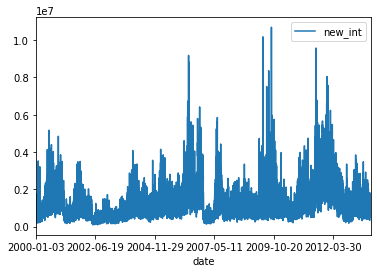

In [94]:
volume_chart=sector_volume_mean['BASIC INDUSTIRES'].plot(y='new_int',kind="line")

In [95]:
sector_volume_mean

,sector,new_int
date,,
2000-01-03,BASIC INDUSTRIES,368480
2000-01-04,BASIC INDUSTRIES,426934
2000-01-05,BASIC INDUSTRIES,564982
2000-01-06,BASIC INDUSTRIES,661672
2000-01-07,BASIC INDUSTRIES,636476
2000-01-10,BASIC INDUSTRIES,460887
2000-01-11,BASIC INDUSTRIES,417510
2000-01-12,BASIC INDUSTRIES,535414
2000-01-13,BASIC INDUSTRIES,556309


In [102]:
#sector_volume_mean = sector_volume_mean.reset_index()
#sector_volume_mean
sector_volume_mean_pivot=sector_volume_mean.pivot(index='date',columns='sector')["new_int"]
sector_volume_mean_pivot

sector,BASIC INDUSTRIES,CAPITAL GOODS,CONSUMER DURABLES,CONSUMER NON-DURABLES,CONSUMER SERVICES,ENERGY,FINANCE,HEALTH CARE,MISCELLANEOUS,PUBLIC UTILITIES,TECHNOLOGY,TRANSPORTATION
date,,,,,,,,,,,,
2000-01-03,368480,437852,261755,662930,891057,1032585,426291,1335435,3515958,699883,3597019,587734
2000-01-04,426934,444233,228996,697814,992288,1151981,574677,1260868,2230605,708610,3670762,698205
2000-01-05,564982,501580,246252,774141,1106458,1330348,452257,1206767,2884413,825930,4785576,695883
2000-01-06,661672,498945,295837,792036,1100446,1469440,449839,1301663,2639447,643578,3819150,880357
2000-01-07,636476,535657,239028,904997,952810,1323360,395818,1912996,1521522,702410,3706094,771068
2000-01-10,460887,423000,289639,669570,982222,909036,368508,1496816,1770136,572062,3413204,736018
2000-01-11,417510,411822,265856,701855,877156,946930,364007,1230439,1664599,602746,3340924,656779
2000-01-12,535414,451105,257746,682060,805512,936734,356765,1121577,1533637,618428,4019832,644029
2000-01-13,556309,418367,268220,594075,875746,1061263,476608,1265223,1381648,827085,3721500,671725


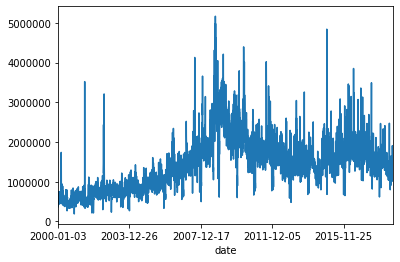

In [104]:
volume_chart=sector_volume_mean_pivot['BASIC INDUSTRIES'].plot(y='new_int',kind="line")